# SHRED for ROMs: interpolation - sensors UQ

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, which is hyperparameter tuned.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
import pandas as pd

_, is_vector, times = pickle.load(open('msfr_uloff.set', 'rb'))

path_svd = './OfflineSVD/'
u_total = pickle.load(open(path_svd+'u_total.svd', 'rb'))
v_total = pickle.load(open(path_svd+'v_total.svd', 'rb'))
s_total = pickle.load(open(path_svd+'s_total.svd', 'rb'))

var_names = pickle.load(open(path_svd+"var.names", 'rb'))
rescaling_snaps = pickle.load(open(path_svd+"rescaling.svd", 'rb'))
Nmodes = pickle.load(open(path_svd+"Nmodes.svd", 'rb'))

measure = 'outcore-random' # 'outcore-random', 'incore-random', 'outcore-eim
if measure == 'incore-random':
  measurements = pickle.load(open(path_svd+'measurements_incore.data', 'rb'))
elif measure == 'outcore-eim':
  measurements = pickle.load(open(path_svd+'measurements_EIM.data', 'rb'))
else:
  measurements = pickle.load(open(path_svd+'measurements_3.data', 'rb'))
  # measurements = pickle.load(open(path_svd+'measurements_10.data', 'rb'))

Let us extract the number of modes

In [2]:
Nvariables = len(var_names)
n_configurations = measurements['location'].shape[1]
num_sensors = measurements['noisy_output'].shape[0]

assert measurements['noisy_output'].shape[2] == n_configurations

Ns = measurements['noisy_output'].shape[1]
new_t = np.linspace(times[0], times[-1], Ns)

Let us define the tex variables

In [5]:
energy_groups = 6
tex_var_names = [r'\phi_'+str(g+1) for g in range(energy_groups)]

prec_groups = 8
tex_var_names.extend([r'c_'+str(g+1) for g in range(prec_groups)])

dec_groups = 3
tex_var_names.extend([r'd_'+str(g+1) for g in range(dec_groups)])

tex_var_names.extend(['T', 'p', r'\mathbf{u}'])

assert len(tex_var_names) == len(var_names)

Here the necessary packages for SHRED are loaded

In [7]:
import sys
sys.path.append('../../') # to include the SHRED modules

from shred.processdata import TimeSeriesDataset
import shred.models as models
import torch
from sklearn.preprocessing import MinMaxScaler
import os

if measure == 'incore-random':
    path_shred = './SHRED/InCore/'
elif measure == 'outcore-eim':
    path_shred = './SHRED/EIM/'
else:
    path_shred = './SHRED/'
    
if not os.path.exists(path_shred):
    os.makedirs(path_shred)

## Training the SHRED models
For each sensor, a SHRED net is trained. 

Choose either MPS or cuda according to your device

In [9]:
from IPython.display import clear_output

lags = 52
_load_X = v_total.T
sensor_locations = np.arange(0, num_sensors, 1, dtype=int) # [0,1,2]

shred = list()
test_datasets = list()

train_net = True

################################################################################################################

for kk in range(n_configurations):
    
    print('Training SHRED - configuration '+str(kk+1)+'/'+str(n_configurations))

    # Creating input data
    Xsensor = measurements['noisy_output']
    load_X = np.hstack((Xsensor[:,:,kk].T,_load_X))

    m = load_X.shape[1]
    assert m == sum(Nmodes) + num_sensors
    
    # GPU
    # device = 'cuda' if torch.cuda.is_available() else 'cpu' # Linux
    device = 'mps' if torch.backends.mps.is_available() else 'cpu' # MacOS

    shred.append(models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, decoder_sizes=[350, 400], dropout=0.1).to(device))

    if train_net:
        # Reconstruction - splitting into train, test and validation
        train_indices = np.random.choice(Ns - lags, size=350, replace=False)
        mask = np.ones(Ns - lags)
        mask[train_indices] = 0
        valid_test_indices = np.arange(0, Ns - lags)[np.where(mask!=0)[0]]
        valid_indices = valid_test_indices[::2]
        test_indices = valid_test_indices[1::2]
        
        # sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 
        sc = MinMaxScaler()
        sc = sc.fit(load_X[train_indices])
        transformed_X = sc.transform(load_X)

        ### Generate input sequences to a SHRED model
        all_data_in = np.zeros((Ns - lags, lags, num_sensors))
        for i in range(len(all_data_in)):
            all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

        ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
        train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
        valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
        test_data_in  = torch.tensor(all_data_in[test_indices],  dtype=torch.float32).to(device)

        ### -1 to have output be at the same time as final sensor measurements
        train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
        valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
        test_data_out  = torch.tensor(transformed_X[test_indices + lags - 1],  dtype=torch.float32).to(device)

        train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
        valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
        test_dataset  = TimeSeriesDataset(test_data_in, test_data_out)

        ### Store the test_datasets for later use
        test_datasets.append({  'X': test_dataset.X,
                                'Y': test_dataset.Y,
                                'idx': test_indices})

        validation_errors = models.fit(shred[kk], train_dataset, valid_dataset, batch_size=64, epochs=3000, lr=1e-3, verbose=True, patience=50)
        
        if num_sensors != 3:
            torch.save(shred[kk].state_dict(), path_shred+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'sens_'+var_names[measurements['measured_field']]+'.shred')
            pickle.dump(test_datasets, open(path_shred+'datasets_measuring_'+str(num_sensors)+'.test', 'wb'))
        else:
            torch.save(shred[kk].state_dict(), path_shred+'trained_config'+str(kk)+'_measuring_'+var_names[measurements['measured_field']]+'.shred')
            pickle.dump(test_datasets, open(path_shred+'datasets.test', 'wb'))

        clear_output()
    else:
        if num_sensors != 3:
            shred[kk].load_state_dict(torch.load(path_shred+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'sens_'+var_names[measurements['measured_field']]+'.shred'))
            test_datasets = pickle.load(open(path_shred+'datasets_measuring_'+str(num_sensors)+'.test', 'rb'))
        else:
            shred[kk].load_state_dict(torch.load(path_shred+'trained_config'+str(kk)+'_measuring_'+var_names[measurements['measured_field']]+'.shred'))
            test_datasets = pickle.load(open(path_shred+'datasets.test', 'rb'))

## Testing SHRED
In this section, the reliability of the SHRED network are assessed.

Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [10]:
if measure == 'incore-random':
    path_test = './Test_results/InCore/'
elif measure == 'outcore-eim':
    path_test = './Test_results/EIM/'
else:
    path_test = './Test_results/'
    
    if num_sensors != 3:
        path_test += 'Measuring_'+str(num_sensors)+'/'
    
if not os.path.exists(path_test):
    os.makedirs(path_test)  

if train_net:
    test_recons = list()
    test_ground_truth = list()

    relative_test_errors = list()

    for kk in range(n_configurations):
        test_recons.append(sc.inverse_transform(shred[kk](test_datasets[kk]['X']).detach().cpu().numpy()))
        test_ground_truth.append(sc.inverse_transform(test_datasets[kk]['Y'].detach().cpu().numpy()))
        
        relative_test_errors.append(np.linalg.norm(test_recons[kk] - test_ground_truth[kk]) / np.linalg.norm(test_ground_truth[kk]))
        
    pickle.dump([test_recons, test_ground_truth, relative_test_errors], open(path_test+'test.results', 'wb'))
else:
    test_recons, test_ground_truth, relative_test_errors = pickle.load(open(path_test+'test.results', 'rb'))

Let us plot the error bars

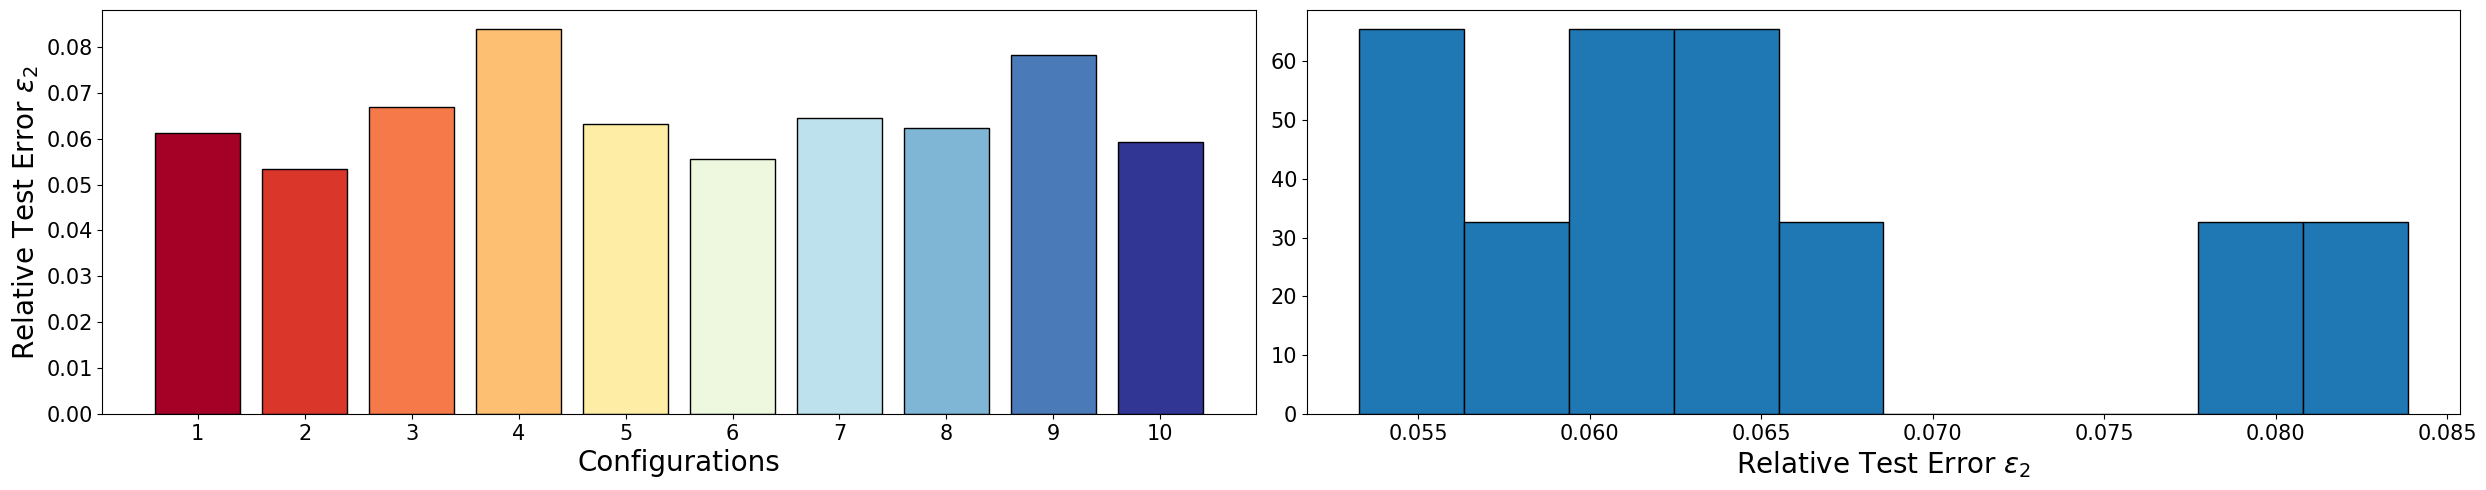

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25,5))

# Bars
axs[0].bar(np.arange(1, n_configurations+1, 1), relative_test_errors, 
        color = cm.RdYlBu(np.linspace(0,1,len(relative_test_errors))),
        edgecolor='k')

axs[0].set_xticks(np.arange(1, n_configurations+1, 1))
axs[0].set_xlabel(r'Configurations', fontsize=20)
axs[0].set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=20)

# Histogram
axs[1].hist(relative_test_errors, edgecolor='k', density=True)
axs[1].set_xlabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=20)

[ax.tick_params(axis='both', labelsize=15) for ax in axs]

plt.tight_layout()

### Uncertainty Quantification

At first, the mean and the standard deviation of the output of each configuration of SHRED models is computed using bins (this is required since the time input dataset is not the same for wach configuration).

In [14]:
from pyforce.tools.backends import LoopProgress

binned_stats = list()

# Determine time bins
bin_width = 0.25

bar = LoopProgress('Evaluate Mean&Std for SHRED output', final = sum(Nmodes))

for mode in range(num_sensors, sum(Nmodes) + num_sensors):
    
    data = pd.DataFrame({
        'time': np.hstack([new_t[_test['idx']] for _test in test_datasets]),
        'value': np.hstack([_test[:,mode] for _test in test_recons]),
    })

    # Compute bins
    bins = np.arange(0, max(data['time']) + bin_width, bin_width)

    # Assign each data point to a bin
    data['bin'] = pd.cut(data['time'], bins, right=False)

    # Calculate mean and standard deviation within each bin
    binned_stats_tmp = data.groupby('bin', observed=True)['value'].agg(['mean', 'std']).reset_index()

    # Calculate bin centers for plotting
    binned_stats_tmp['time'] = bins[:-1] + bin_width / 2

    # Remove bins without data
    binned_stats.append(binned_stats_tmp.dropna())
    
    bar.update(1)
pickle.dump(binned_stats, open(path_test+'binned.statitics', 'wb'))

Evaluate Mean&Std for SHRED output: 200.000 / 200.00 - 0.002 s/it


Let us plot the output of the SHRED networks considering their mean and standard deviation

In [15]:
bar = LoopProgress('Plotting SHRED Output UQ', len(var_names))

for field_i in range(len(var_names)):

    nrows = 2
    ncols = 5
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(6 * ncols, 5 * nrows))
    axs = axs.flatten()

    colors = cm.jet([0.1, 0.25, 0.9])
    ls = 2

    for rr in range(Nmodes[field_i]):
        
        mode = field_i * Nmodes[field_i] + rr
        
        axs[rr].plot(binned_stats[mode]['time'], binned_stats[mode]['mean'], c=colors[0], label=r'Mean Prediction', linewidth=ls)
        axs[rr].fill_between(   binned_stats[mode]['time'], 
                                y1 = binned_stats[mode]['mean'] - 1.96 * binned_stats[mode]['std'],
                                y2 = binned_stats[mode]['mean'] + 1.96 * binned_stats[mode]['std'],
                                color=colors[1], alpha=0.3, label=r'95\% Confidence Interval')

        axs[rr].plot(new_t[test_datasets[-1]['idx']], test_ground_truth[-1][:, mode+num_sensors], '--', c=colors[2], label=r'Ground Truth', linewidth=ls)
        axs[rr].set_ylabel(r'$v_{'+str(rr+1)+'}^{'+tex_var_names[field_i]+r'}$', fontsize=20)
        axs[rr].grid()

        axs[rr].set_xlim(min(times), max(times))
        # axs[rr].legend(fontsize=20)
        axs[rr].tick_params(axis='both', labelsize=15)

    Line, Label = axs[0].get_legend_handles_labels()
    fig.legend(Line, Label, fontsize=25, ncols=3, framealpha=1, loc=(0.2, 0.9325))

    axs = axs.reshape(nrows, ncols)
    [ax.set_xlabel(r'Time $t$ (s)', fontsize=20) for ax in axs[1]]

    fig.subplots_adjust(hspace=0.05, top = 0.925, wspace=0.4)
    fig.savefig(path_test+'SHRED_output_uq_'+var_names[field_i]+'.pdf', format='pdf', dpi=250, bbox_inches='tight')
    plt.close(fig)
    
    bar.update(1)

Plotting SHRED Output UQ: 20.000 / 20.00 - 0.333 s/it


Let us plot the first 5 temporal dynamical the reduced coefficients for each field

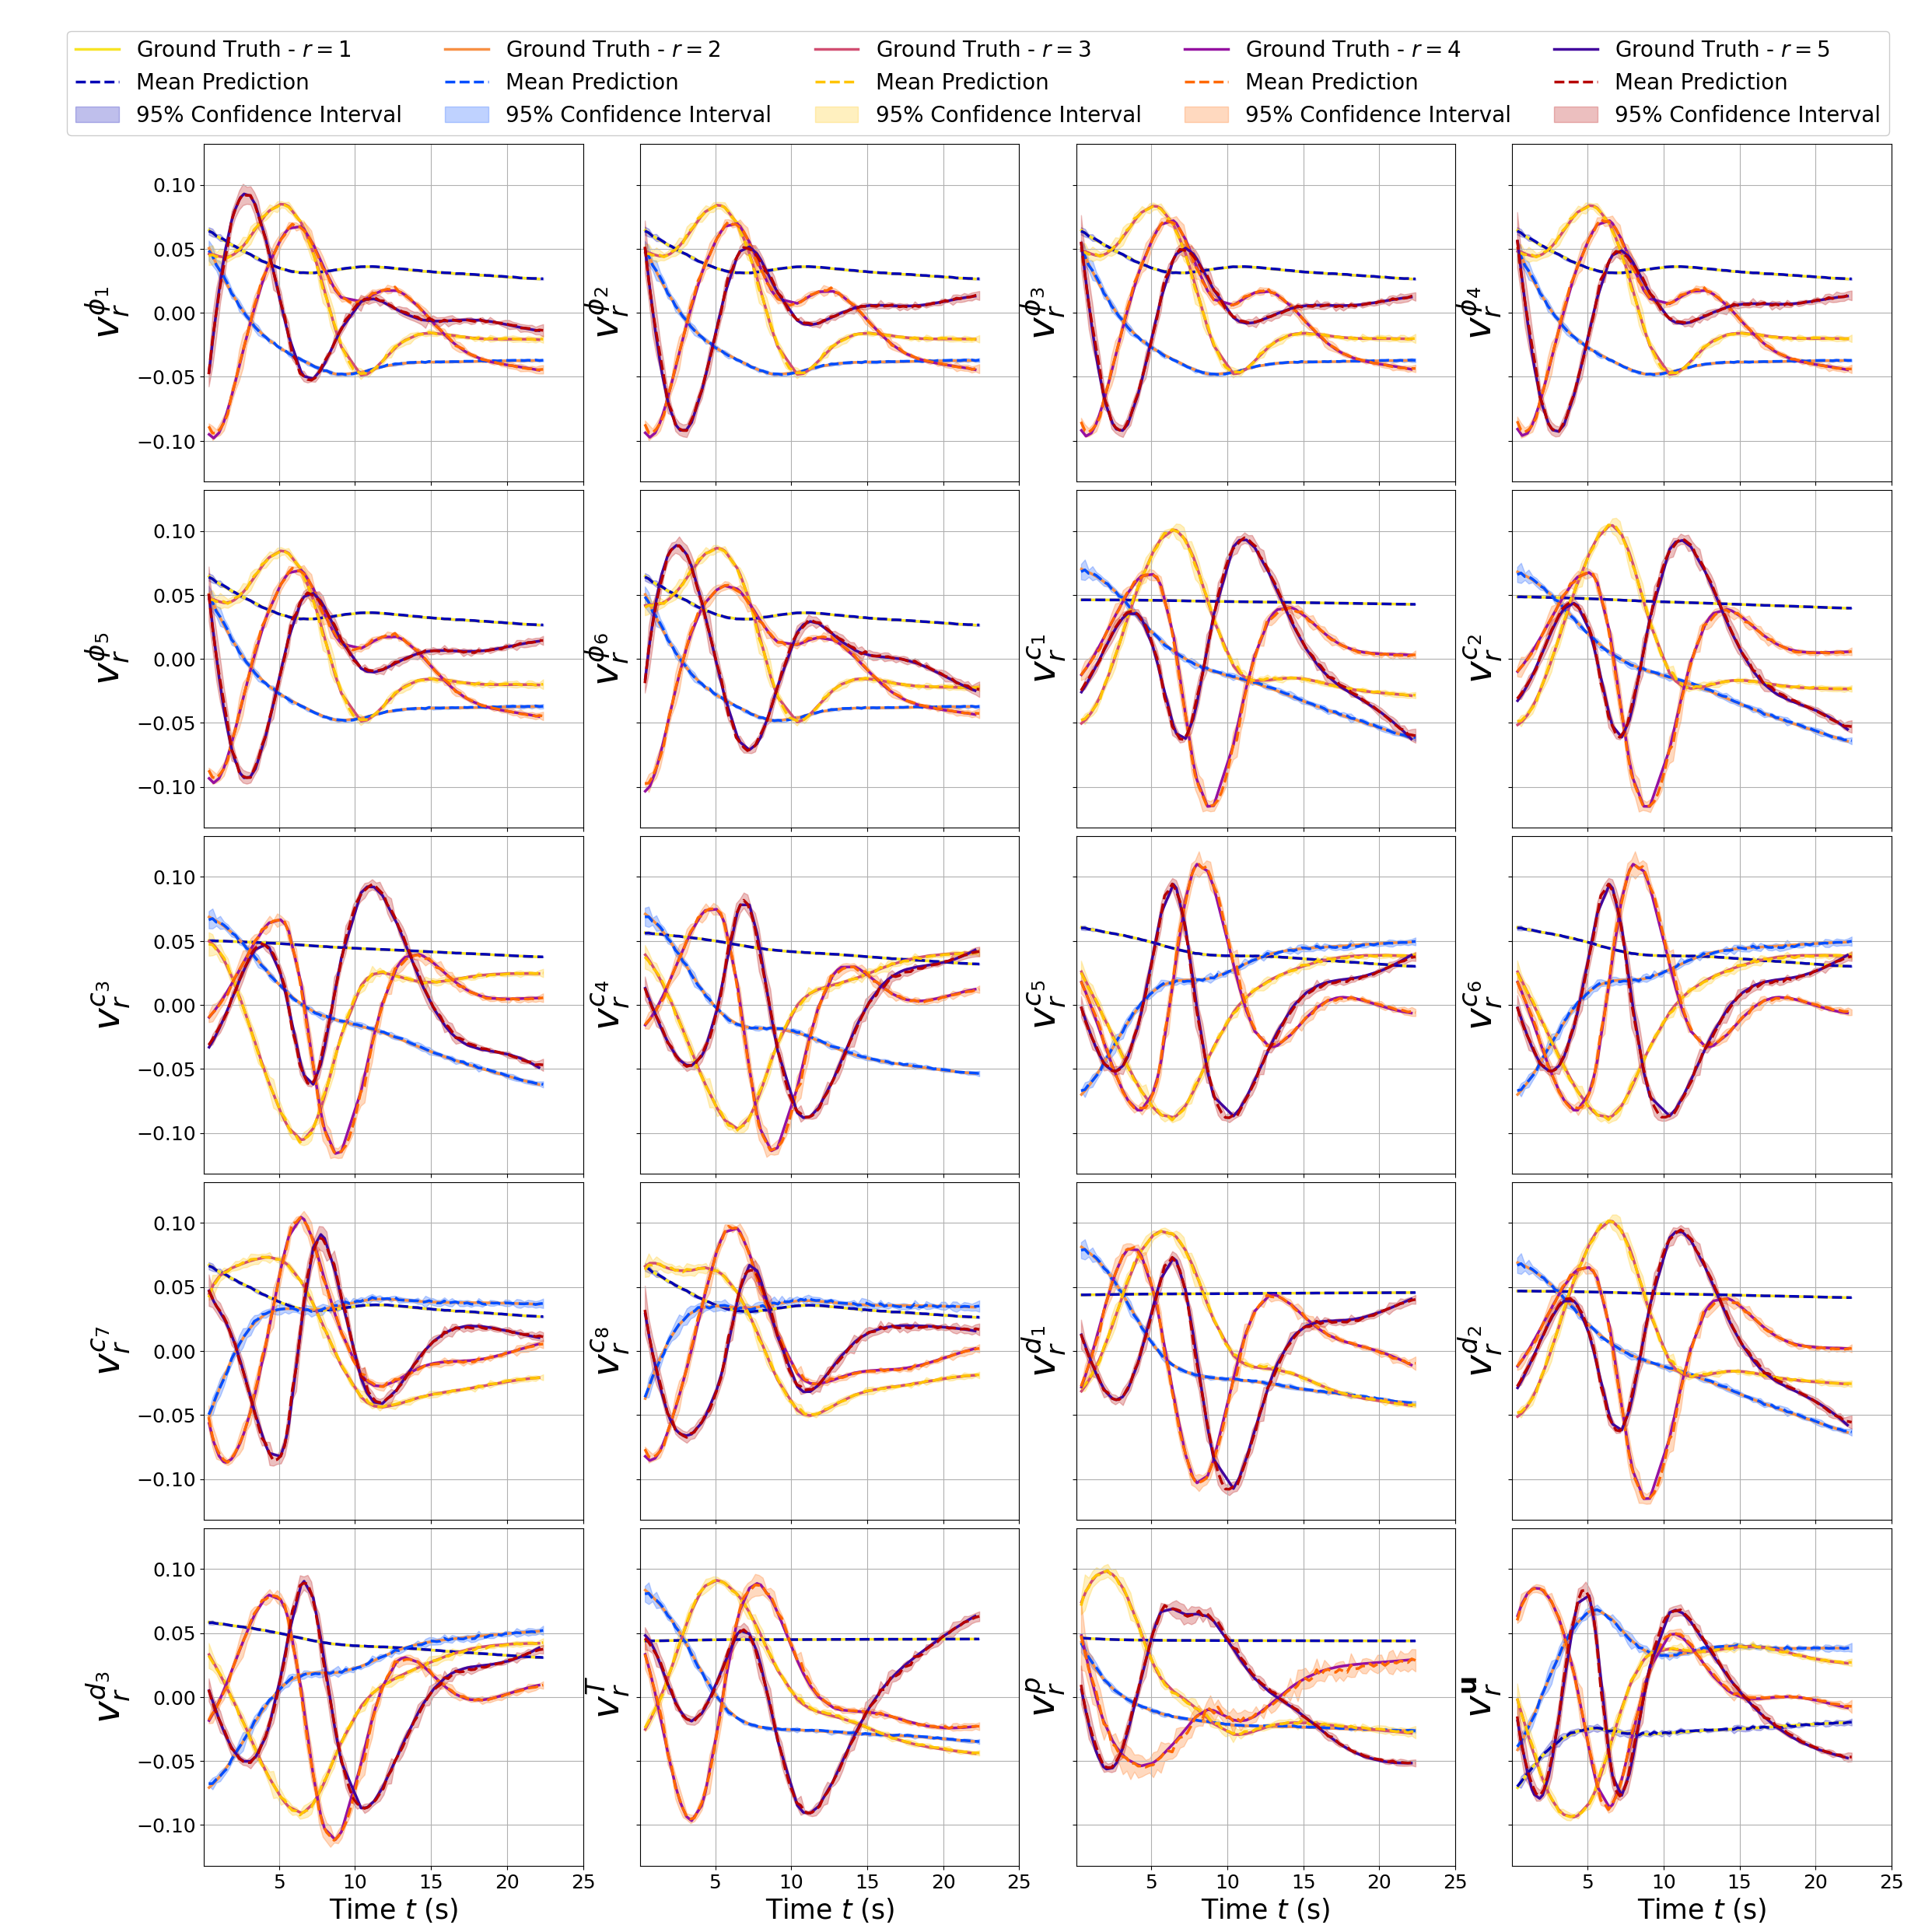

In [16]:
modes_to_plot = 5
    
nrows = 5
ncols = 4
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, sharey=True, figsize=(7 * ncols, 5.5 * nrows))
axs = axs.flatten()

ls = 2.5

for field_i, field in enumerate(var_names):

    idx_to_plot = np.arange(sum(Nmodes[:field_i]),
                            modes_to_plot + sum(Nmodes[:field_i]),
                            1, 
                            dtype=int)

    # colors = cm.jet(np.linspace(0.,1,len(idx_to_plot)))
    colors = cm.jet([0.05, 0.2, 0.7, 0.8, 0.95])
    colors_gt = cm.plasma(np.linspace(0.1,0.95,len(idx_to_plot)))
    for ii, idx in enumerate(idx_to_plot):
        axs[field_i].plot(new_t[test_datasets[-1]['idx']], test_ground_truth[-1][:, idx+num_sensors], '-', linewidth=ls, c=colors_gt[-1-ii], label=r'Ground Truth - $r='+str(ii+1)+'$')

        axs[field_i].plot(binned_stats[idx]['time'], binned_stats[idx]['mean'], '--', c=colors[ii], label=r'Mean Prediction', linewidth=ls)
        axs[field_i].fill_between(  binned_stats[idx]['time'], 
                                    y1 = binned_stats[idx]['mean'] - 1.96 * binned_stats[idx]['std'],
                                    y2 = binned_stats[idx]['mean'] + 1.96 * binned_stats[idx]['std'],
                                    color=colors[ii], alpha=0.25, label=r'95% Confidence Interval')

    axs[field_i].set_ylabel(r'$v_r^{'+tex_var_names[field_i]+r'}$', fontsize=35)
    axs[field_i].grid()

    axs[field_i].set_xticks(np.arange(0,25.0001, 5))
    axs[field_i].set_xlim(min(times), max(times))
    axs[field_i].tick_params(axis='both', labelsize=18)
    # axs[field_i].legend(loc=(1.025, 0.35), ncols=2)
    
Line, Label = axs[0].get_legend_handles_labels()
fig.legend(Line, Label, fontsize=20, ncols=5, framealpha=1, loc=(0.035, 0.93))

axs = axs.reshape(nrows, ncols)
[ax.set_xlabel(r'Time $t$ (s)', fontsize=25) for ax in axs[-1]]

fig.subplots_adjust(hspace=0.025, top = 0.915, wspace=0.15)
fig.savefig(path_test+'SHRED_dynamics_uq.pdf', format='pdf', dpi=250, bbox_inches='tight')

### Decoding to Full Order

In this last section, the output of the SHRED network $\hat{\mathbf{v}}$ is used to estimate the field of interest, using the decoding from the Singular Value Decomposition.

Let us compute some average quantities, related to the average temperature and the core power.

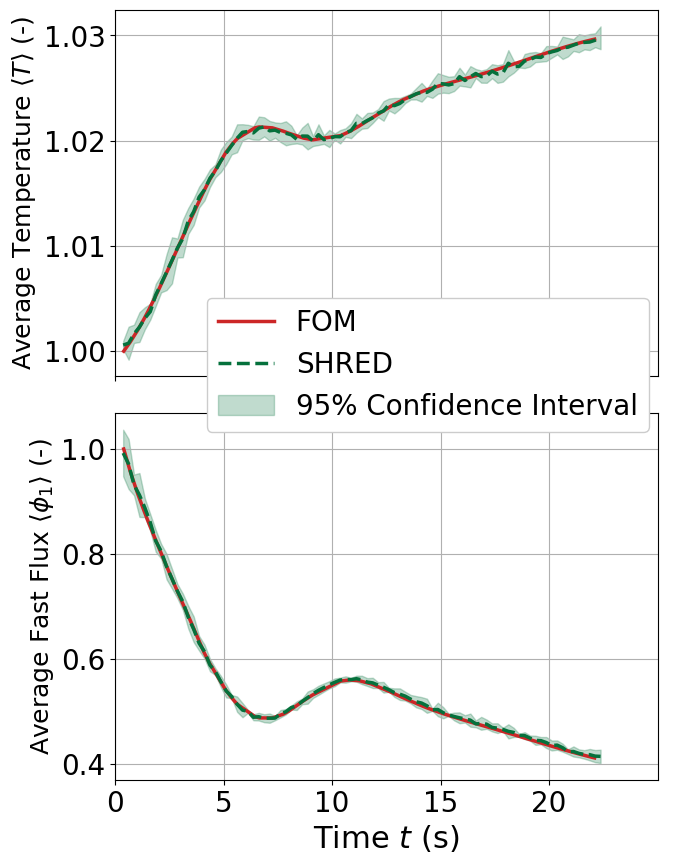

In [17]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (7,10))

cmap = cm.RdYlGn
ls = 2.5

field_i = 17
v_truth = test_ground_truth[-1][:, num_sensors + sum(Nmodes[:field_i]) : num_sensors + sum(Nmodes[:field_i+1])]

u_ = u_total[var_names[field_i]]
s_ = np.diag(s_total[var_names[field_i]])

fom = (u_ @ s_ @ v_truth.T) * rescaling_snaps[field_i]
mean_prediction = (u_ @ s_ @ np.vstack([binned_stats[field_i * Nmodes[field_i] + r]['mean'] for r in range(Nmodes[field_i])])) * rescaling_snaps[field_i]
std_minus_prediction = (u_ @ s_ @ np.vstack([binned_stats[field_i * Nmodes[field_i] + r]['mean'] - 1.96 * binned_stats[field_i * Nmodes[field_i] + r]['std'] for r in range(Nmodes[field_i])])) * rescaling_snaps[field_i]
std_plus_prediction  = (u_ @ s_ @ np.vstack([binned_stats[field_i * Nmodes[field_i] + r]['mean'] + 1.96 * binned_stats[field_i * Nmodes[field_i] + r]['std'] for r in range(Nmodes[field_i])])) * rescaling_snaps[field_i]

axs[0].plot(new_t[test_datasets[-1]['idx']], fom.mean(axis=0) / fom.mean(axis=0)[0], c=cmap(20), label = 'FOM', linewidth = ls)
axs[0].plot(binned_stats[field_i * Nmodes[field_i]]['time'], mean_prediction.mean(axis=0) / fom.mean(axis=0)[0], '--', c=cmap(250), label = 'SHRED', linewidth = ls)
axs[0].fill_between(binned_stats[field_i * Nmodes[field_i]]['time'],
                    y1 = std_minus_prediction.mean(axis=0) / fom.mean(axis=0)[0],
                    y2 = std_plus_prediction.mean(axis=0) / fom.mean(axis=0)[0],
                    color=cmap(250), alpha=0.25, label=r'95% Confidence Interval')

axs[0].set_ylabel(r'Average Temperature $\langle T\rangle$ (-)', fontsize=18)
# axs[0].set_xlabel(r'Time $t$ (s)', fontsize=25)

field_i = 0
v_truth = test_ground_truth[-1][:, num_sensors + sum(Nmodes[:field_i]) : num_sensors + sum(Nmodes[:field_i+1])]

u_ = u_total[var_names[field_i]]
s_ = np.diag(s_total[var_names[field_i]])

fom = (u_ @ s_ @ v_truth.T) * rescaling_snaps[field_i]
mean_prediction = (u_ @ s_ @ np.vstack([binned_stats[field_i * Nmodes[field_i] + r]['mean'] for r in range(Nmodes[field_i])])) * rescaling_snaps[field_i]
std_minus_prediction = (u_ @ s_ @ np.vstack([binned_stats[sum(Nmodes[:field_i]) + r]['mean'] - 1.96 * binned_stats[sum(Nmodes[:field_i]) + r]['std'] for r in range(Nmodes[field_i])])) * rescaling_snaps[field_i]
std_plus_prediction  = (u_ @ s_ @ np.vstack([binned_stats[sum(Nmodes[:field_i]) + r]['mean'] + 1.96 * binned_stats[sum(Nmodes[:field_i]) + r]['std'] for r in range(Nmodes[field_i])])) * rescaling_snaps[field_i]

axs[1].plot(new_t[test_datasets[-1]['idx']], fom.mean(axis=0) / fom.mean(axis=0)[0], c=cmap(20), label = 'FOM', linewidth = ls)
axs[1].plot(binned_stats[field_i * Nmodes[field_i]]['time'], mean_prediction.mean(axis=0) / fom.mean(axis=0)[0], '--', c=cmap(250), label = 'SHRED', linewidth = ls)
axs[1].fill_between(binned_stats[field_i * Nmodes[field_i]]['time'],
                    y1 = std_minus_prediction.mean(axis=0) / fom.mean(axis=0)[0],
                    y2 = std_plus_prediction.mean(axis=0) / fom.mean(axis=0)[0],
                    color=cmap(250), alpha=0.25, label=r'95% Confidence Interval')

axs[1].set_ylabel(r'Average Fast Flux $\langle \phi_1\rangle$ (-)', fontsize=18)
axs[1].set_xlabel(r'Time $t$ (s)', fontsize=22)

for ax in axs:
    ax.grid()
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlim(0,25)
    ax.set_xticks(np.arange(0,25,5))
axs[1].tick_params(axis='both', labelsize=20)

Line, Label = axs[0].get_legend_handles_labels()
fig.legend(Line, Label, fontsize=20, ncols=1, framealpha=1, loc=(0.3, 0.5))

fig.subplots_adjust(wspace=0.025, hspace = 0.1)
fig.savefig(path_test+'SHRED_global_qties.pdf', format='pdf', dpi=250, bbox_inches='tight')

Let us compute the average relative error for generic field $u$ as
\begin{equation*}
\varepsilon_u = \frac{1}{T}\sum_{t=1}^T \frac{\| u_t - \hat{u}_t\|_2}{\| u_t\|_2}
\end{equation*}
given $\hat{u}_t$ the reconstruction at time $t$.

In [18]:
Ns_test = test_recons[0].shape[0]

if train_net:
    ave_rel_errors = np.zeros((Nvariables, Ns_test, n_configurations))

    bar = LoopProgress('Computing relative 2-error', Nvariables)
    for field_i in range(Nvariables):
        
        for kk in range(n_configurations):
            v_truth = test_ground_truth[kk][:, num_sensors + sum(Nmodes[:field_i]) : num_sensors + sum(Nmodes[:field_i+1])]
            v_shred = test_recons[kk][:,       num_sensors + sum(Nmodes[:field_i]) : num_sensors + sum(Nmodes[:field_i+1])]

            u_ = u_total[var_names[field_i]]
            s_ = np.diag(s_total[var_names[field_i]])

            fom = (u_ @ s_ @ v_truth.T) * rescaling_snaps[field_i]
            prediction = (u_ @ s_ @ v_shred.T) * rescaling_snaps[field_i]
            
            ave_rel_errors[field_i, :, kk] = np.linalg.norm(fom - prediction, axis=0) / np.linalg.norm(fom, axis=0)
            
        bar.update(1)
    
    pickle.dump(ave_rel_errors, open(path_test+'fom.errors', 'wb'))
else:
    ave_rel_errors = pickle.load(open(path_test+'fom.errors', 'rb'))

Computing relative 2-error: 20.000 / 20.00 - 0.253 s/it


Let us plot the errors using bar plots

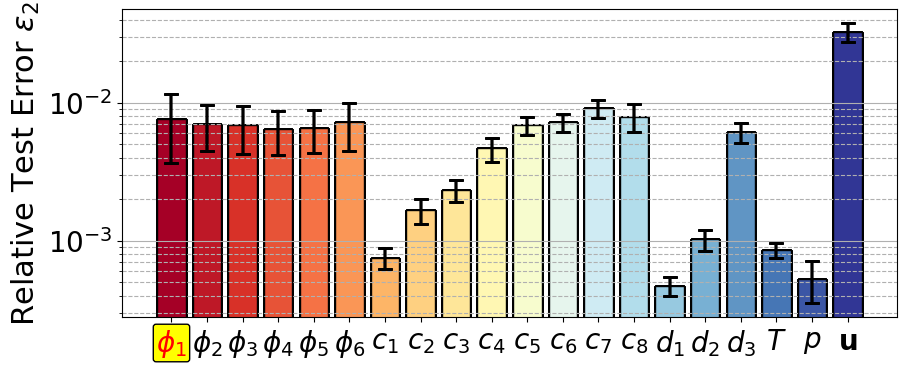

In [19]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(10,4))

colors = cm.jet(np.linspace(0,1, len(var_names)))
for field_i in range(len(var_names)):
    # axs.scatter(field_i , np.mean(ave_rel_errors.mean(axis=1), axis=1)[field_i], color=colors[field_i])
    axs.bar(np.arange(1, len(var_names)+1, 1), np.mean(ave_rel_errors.mean(axis=1), axis=1), 
            yerr = np.std(ave_rel_errors.mean(axis=1), axis=1), capsize=5,
            color = cm.RdYlBu(np.linspace(0,1,len(var_names))),
            edgecolor='k')

axs.set_yscale('log')
axs.set_xticks(np.arange(1,len(var_names)+1,1), ['$'+tex_+'$' for tex_ in tex_var_names])
# axs.set_yticks(np.arange(0,0.1,0.01))

# Highlight the tick label at measured field
xticks = axs.get_xticklabels()
xticks[0].set_color('red')
xticks[0].set_bbox(dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.1'))

axs.tick_params(axis='both', labelsize=20)
axs.set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=22)
axs.grid(axis='y', linestyle='-')
axs.grid(axis='y', which='minor', linestyle='--')

fig.savefig(path_test+'fom_relativerrror_bars.pdf', format='pdf', dpi=250, bbox_inches='tight')

Let us plot the errors using violin or box plots

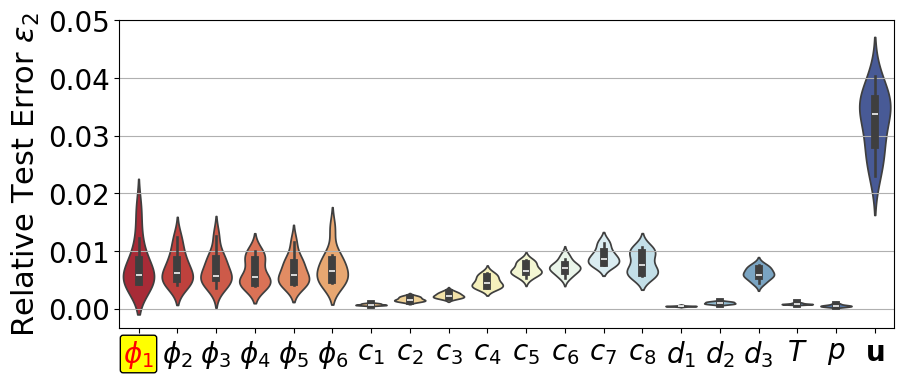

In [22]:
import seaborn as sns

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,4))

plot_type = 0

if plot_type == 0: # violin 
    sns.violinplot(data=ave_rel_errors.mean(axis=1).T, ax=axs, palette='RdYlBu')
elif plot_type == 1: # box
    sns.boxplot(data=ave_rel_errors.mean(axis=1).T, ax=axs, palette='RdYlBu')

axs.set_xticks(np.arange(len(var_names)))
axs.set_xticklabels(['$'+tex_+'$' for tex_ in tex_var_names])
# axs.set_yscale('log')
axs.set_xticks(np.arange(0,len(var_names),1), ['$'+tex_+'$' for tex_ in tex_var_names])
axs.set_yticks(np.arange(0,0.05+1e-12,0.01))

# Highlight the tick label at measured field
xticks = axs.get_xticklabels()
xticks[0].set_color('red')
xticks[0].set_bbox(dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.1'))

axs.tick_params(axis='both', labelsize=20)
axs.set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=22)
axs.grid(axis='y', linestyle='-')

fig.savefig(path_test+'fom_relativerrror_violin.pdf', format='pdf', dpi=250, bbox_inches='tight')

In the end, let us make the heat map of the errors

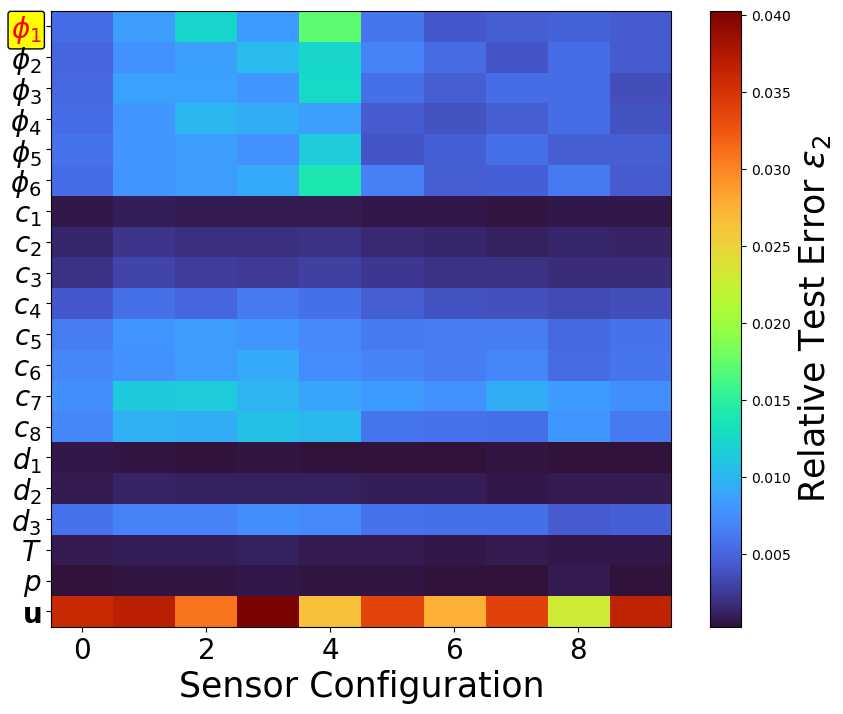

In [23]:
fig, axs = plt.subplots(figsize=(10,8))

heat_map = axs.imshow(ave_rel_errors.mean(axis=1), cmap=cm.turbo, aspect='auto')

axs.set_xlabel(r'Sensor Configuration', fontsize=25)
axs.set_yticks(np.arange(len(var_names)), labels=['$'+tex_+'$' for tex_ in tex_var_names])
axs.tick_params(axis='both', labelsize=20)
cbar = plt.colorbar(heat_map)
cbar.set_label(r'Relative Test Error $\varepsilon_{2}$', fontsize=25)

# Highlight the tick label at measured field
yticks = axs.get_yticklabels()
yticks[0].set_color('red')
yticks[0].set_bbox(dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.1'))

fig.savefig(path_test+'fom_relativerrror_heatmap.pdf', format='pdf', dpi=250, bbox_inches='tight')

# # Loop over data dimensions and create text annotations
# for i in range(len(var_names)):
#     for j in range(n_configurations):
#         text = axs.text(j, i, ave_rel_errors.mean(axis=1)[i, j],
#                        ha="center", va="center", color="w")